In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [35]:
# Load data
train_set = pd.read_csv("train_cleandata.csv")
test_set = pd.read_csv("test_cleandata.csv")
train_set

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
0,2015-03-11,2,sewing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57,0.700505,3
1,2015-02-02,1,finishing,Monday,1,0.75,3.94,0.0,2280,0,0.0,0,0,19,0.504596,2
2,2015-01-05,1,finishing,Monday,10,0.75,2.90,0.0,960,0,0.0,0,0,8,0.763375,1
3,2015-02-12,2,finishing,Thursday,4,0.70,4.15,0.0,1800,0,0.0,0,0,15,1.000000,2
4,2015-01-08,2,sewing,Thursday,12,0.80,11.61,548.0,15120,63,0.0,0,0,31,0.800107,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,2015-03-03,1,finishing,Tuesday,5,0.70,4.60,0.0,3360,0,0.0,0,0,8,0.354444,3
953,2015-03-07,1,finishing,Saturday,6,0.50,2.90,0.0,960,0,0.0,0,0,8,0.797500,3
954,2015-03-09,2,finishing,Monday,5,0.60,3.94,0.0,0,2880,0.0,0,0,12,0.864343,3
955,2015-02-19,3,sewing,Thursday,7,0.75,30.10,444.0,0,0,5.0,20,1,59,0.611141,2


In [36]:


# Convert categorical variables to categorical dtype
categorical_cols = ["quarter", "day", "team", "department", "month"]
train_set[categorical_cols] = train_set[categorical_cols].astype("category")
test_set[categorical_cols] = test_set[categorical_cols].astype("category")

# Define predictors
department_predictors = [
    "targeted_productivity", "smv", "over_time", "incentive", 
    "idle_time", "idle_men", "no_of_workers", "team", "quarter", "day", "month"
]

department_predictors_finishing = [
    "targeted_productivity", "smv", "over_time", "no_of_workers", "team"
]

overall_predictors = department_predictors + ["department"]

# Configuration
DEPARTMENTS = {
    "Sewing": department_predictors,
    "Finishing": department_predictors_finishing,
    "Overall": overall_predictors
}

OUTLIER_METHODS = {
    "isolation_forest": IsolationForest(contamination=0.1, random_state=42),
    "none": None
}

def prepare_data(train, test, predictors, outlier_method):
    """Preprocess data with specified outlier handling"""
    # Detect and remove outliers
    train_clean = detect_outliers(train, outlier_method)
    test_clean = detect_outliers(test, outlier_method)
    
    # Separate features and target
    X_train = train_clean[predictors]
    X_test = test_clean[predictors]
    y_train = train_clean["actual_productivity"]
    y_test = test_clean["actual_productivity"]
    
    return X_train, X_test, y_train, y_test

def detect_outliers(data, method):
    """Detect outliers using specified method"""
    if method == "none":
        return data
    
    detector = OUTLIER_METHODS[method]
    numeric_cols = data.select_dtypes(include=np.number).columns
    detector.fit(data[numeric_cols])
    inliers = detector.predict(data[numeric_cols]) == 1
    return data[inliers]

# Model parameters
MODEL_PARAMS = {
    'ridge': {
        'model__alpha': np.logspace(-3, 3, 100),  # Regularization strength
        'model__fit_intercept': [True, False],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']
    },
    'lasso': {
        'model__alpha': np.logspace(-3, 3, 100),
        'model__fit_intercept': [True, False],
        'model__max_iter': [1000, 2000, 3000]
    },
    'elastic_net': {
        'model__alpha': np.logspace(-3, 3, 100),
        'model__l1_ratio': np.linspace(0, 1, 10),
        'model__fit_intercept': [True, False],
        'model__max_iter': [1000, 2000, 3000]
    }
}

def train_model(X_train, y_train, model_type):
    """Model parameter tuning"""
    # Create preprocessing and model pipeline
    model_pipe = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), 
             X_train.select_dtypes(include=['category']).columns),
            ('num', StandardScaler(), 
             X_train.select_dtypes(include=np.number).columns)
        ])),
        ('model', Ridge() if model_type == 'ridge' else Lasso() if model_type == 'lasso' else ElasticNet())
    ])
    
    search = RandomizedSearchCV(
        model_pipe, 
        MODEL_PARAMS[model_type],
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        error_score='raise'
    )
    
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def run_analysis(department, outlier_method, model_type):
    """Updated analysis pipeline for different models"""
    # Get appropriate data
    if department == "Overall":
        train = train_set
        test = test_set
    else:
        train = train_set[train_set["department"] == department.lower()]
        test = test_set[test_set["department"] == department.lower()]
    
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(
        train, test, DEPARTMENTS[department], outlier_method
    )
    
    # Train model
    best_model, best_params = train_model(X_train, y_train, model_type)
    
    # Evaluate
    metrics = {
        "train_mse": mean_squared_error(y_train, best_model.predict(X_train)),
        "test_mse": mean_squared_error(y_test, best_model.predict(X_test)),
        "train_r2": r2_score(y_train, best_model.predict(X_train)),
        "test_r2": r2_score(y_test, best_model.predict(X_test)),
        "best_params": best_params
    }
    
    # Coefficient visualization
    preprocessor = best_model.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()
    coefficients = pd.Series(best_model.named_steps['model'].coef_, index=feature_names)
    
    plt.figure(figsize=(10, 6))
    coefficients.sort_values().plot(kind='barh', color='steelblue')
    plt.title(f'{department} - Feature Coefficients ({model_type.capitalize()})')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.savefig(f"{department} - Feature Coefficients (Ridge).png") 
    plt.show()
    
    # Partial Dependence Plots
    numeric_features = X_train.select_dtypes(include=np.number).columns
    for feature in numeric_features:
        PartialDependenceDisplay.from_estimator(best_model, X_train, [feature])
        plt.suptitle(f'Partial Dependence Plot for {feature}')
        plt.show()
    
    return {
        "department": department,
        "outlier_method": outlier_method,
        "model_type": model_type,
        **metrics
    }

/Users/pasindumadusanka/myenv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+00, tolerance: 1.031e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/pasindumadusanka/myenv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e+00, tolerance: 1.089e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solv

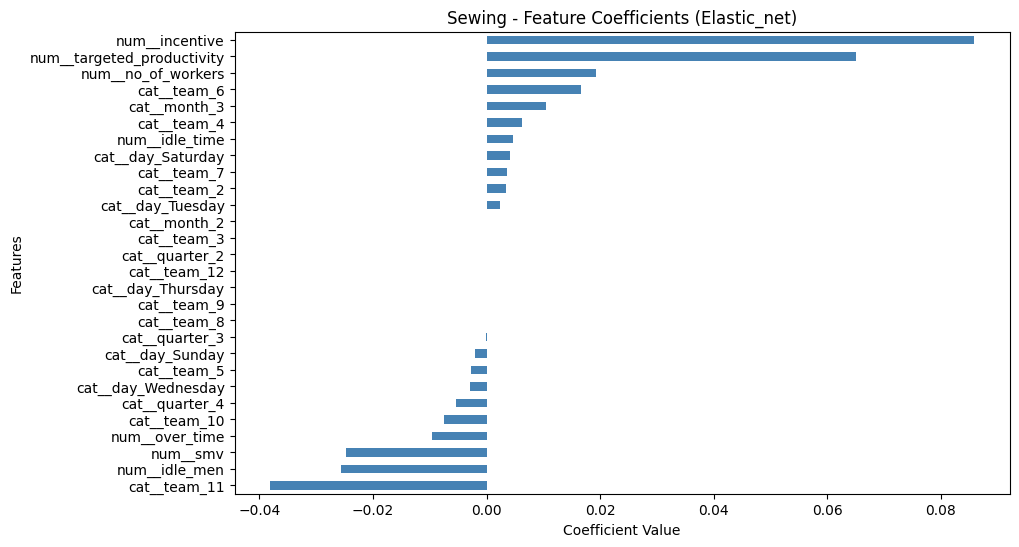

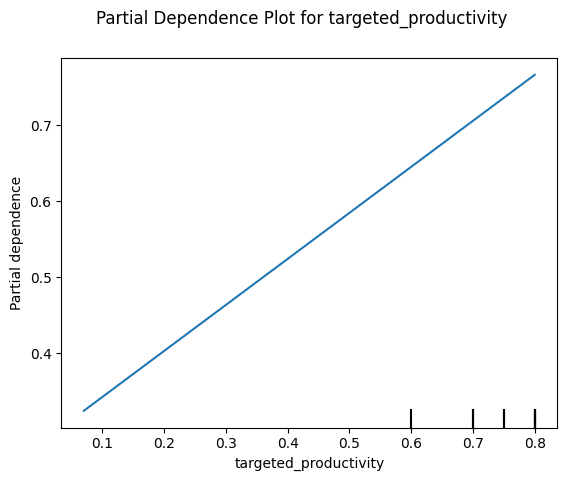

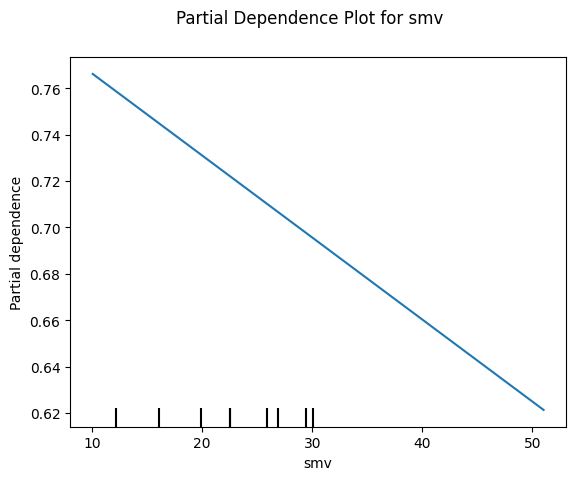

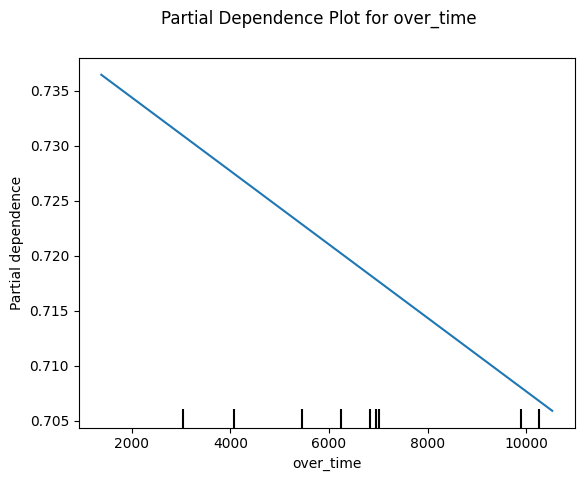

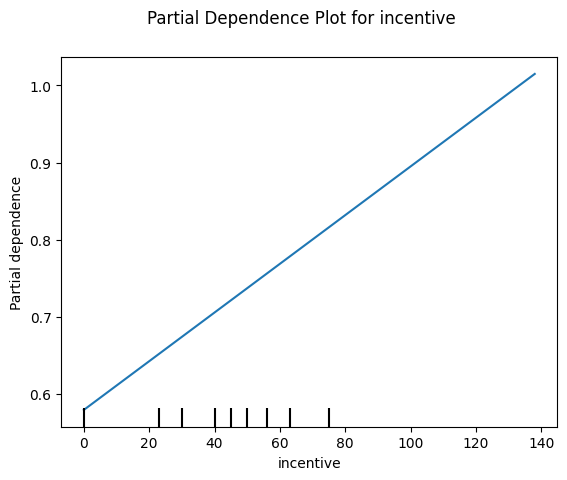

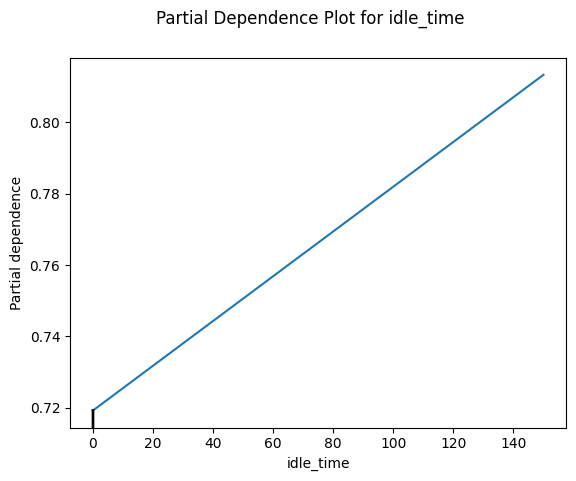

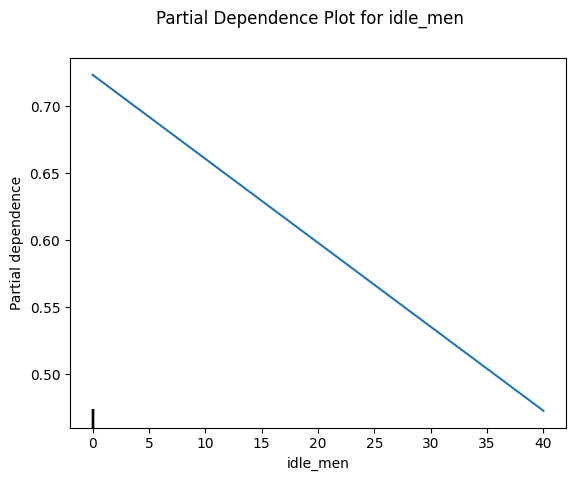

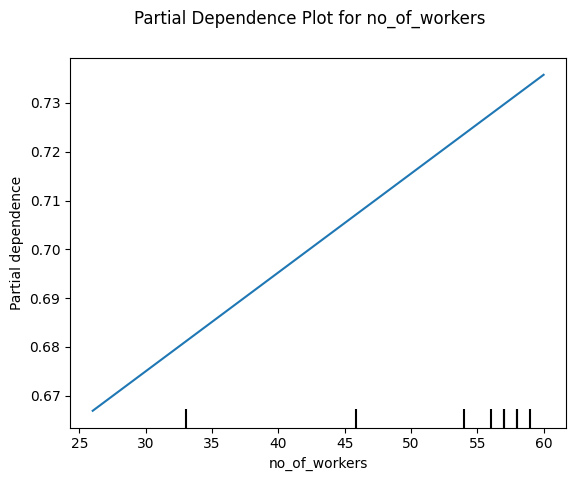

{'department': 'Finishing', 'outlier_method': 'isolation_forest', 'model_type': 'ridge', 'train_mse': 0.03000389939261726, 'test_mse': 0.02590996730835839, 'train_r2': 0.1674655603907328, 'test_r2': 0.17363139606398958, 'best_params': {'model__solver': 'auto', 'model__fit_intercept': True, 'model__alpha': np.float64(35.111917342151344)}}


In [30]:
# Example usage
random.seed(42)
Sewing_results = run_analysis("Sewing", "none", "elastic_net")
print(Finishing_results)

In [28]:
Sewing_results

{'department': 'Sewing',
 'outlier_method': 'none',
 'model_type': 'elastic_net',
 'train_mse': 0.004619686835819895,
 'test_mse': 0.004616053817143128,
 'train_r2': 0.812485566929377,
 'test_r2': 0.775650134380746,
 'best_params': {'model__max_iter': 2000,
  'model__l1_ratio': np.float64(0.2222222222222222),
  'model__fit_intercept': True,
  'model__alpha': np.float64(0.004641588833612782)}}

/Users/pasindumadusanka/myenv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.847e+01, tolerance: 4.267e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/pasindumadusanka/myenv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.912e+01, tolerance: 4.320e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solv

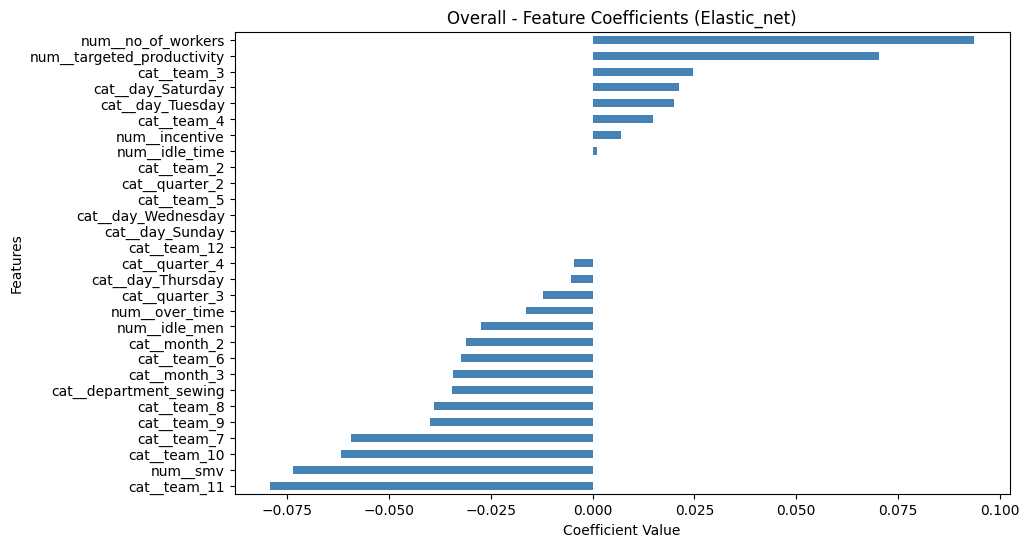

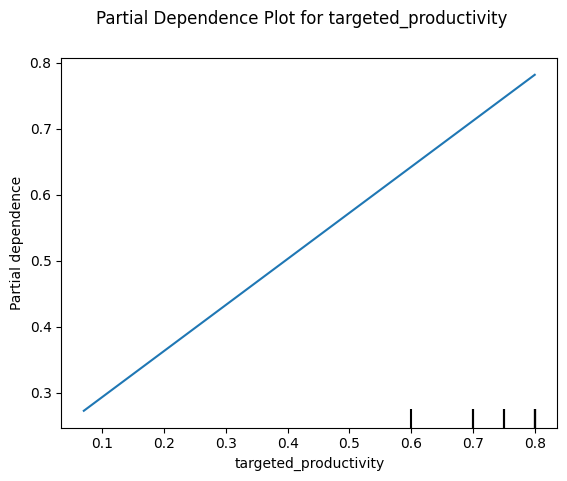

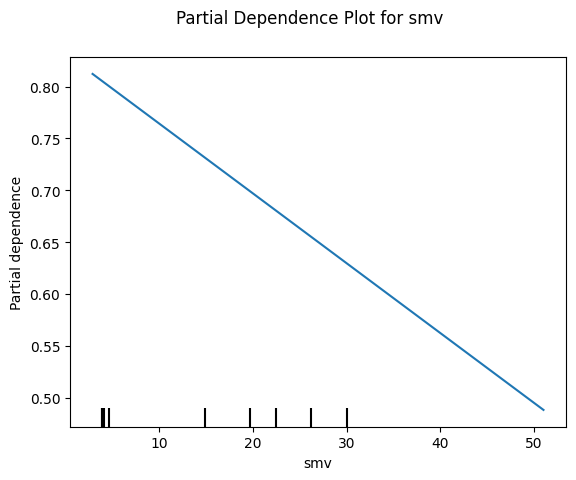

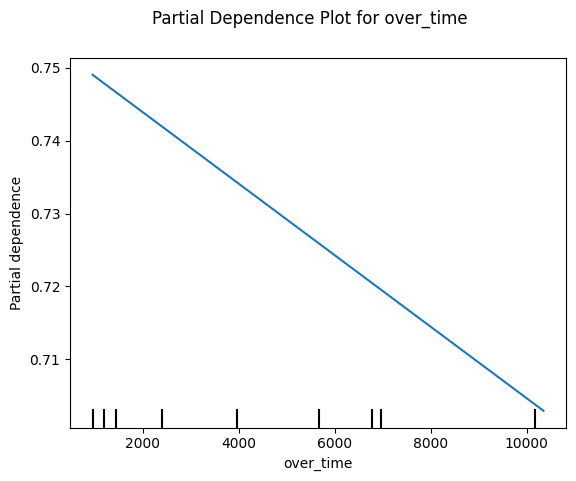

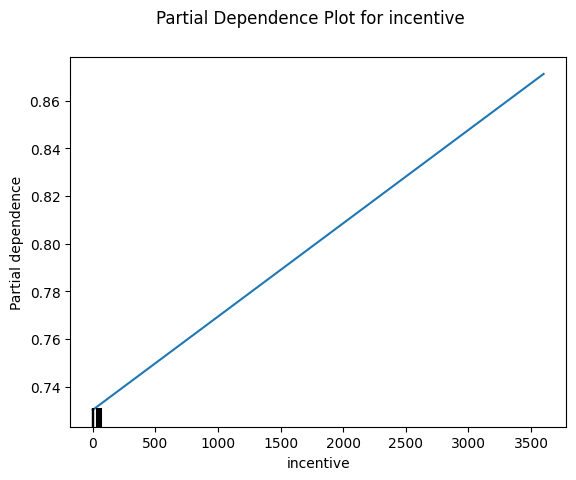

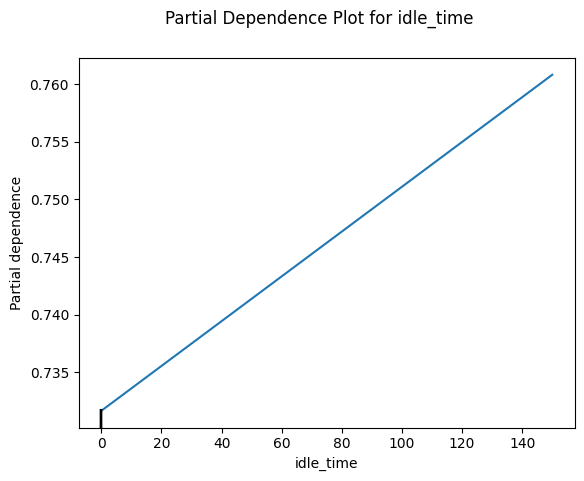

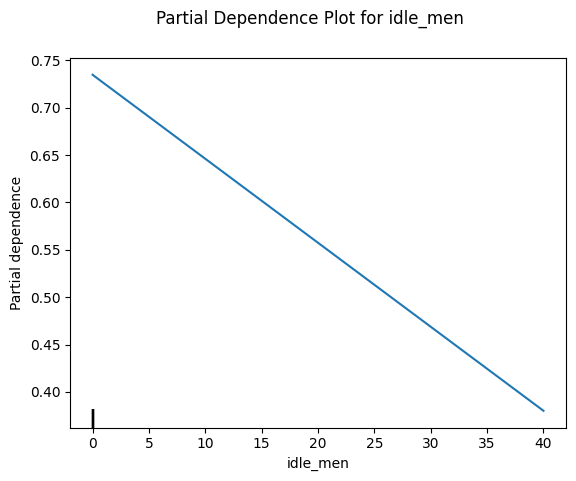

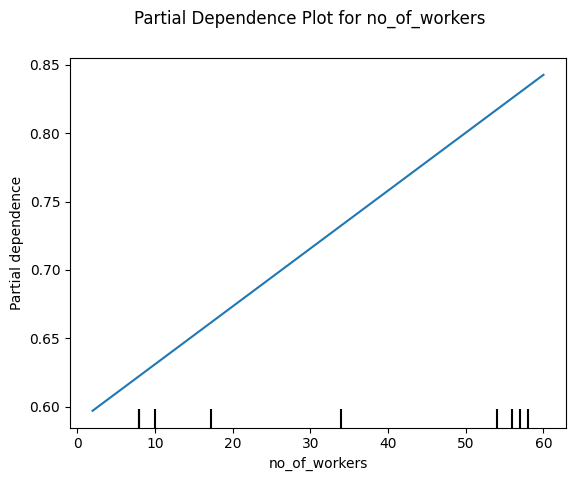

{'department': 'Overall', 'outlier_method': 'none', 'model_type': 'elastic_net', 'train_mse': 0.020847749145276862, 'test_mse': 0.021507762195066595, 'train_r2': 0.32538730415967576, 'test_r2': 0.18620240235076324, 'best_params': {'model__max_iter': 2000, 'model__l1_ratio': np.float64(0.6666666666666666), 'model__fit_intercept': True, 'model__alpha': np.float64(0.0013219411484660286)}}


In [40]:
# Example usage
random.seed(42)

# Run analysis for the "Overall" department
Overall_results = run_analysis("Overall", "none", "elastic_net")
print(Overall_results)  # Print the correct variable